In [48]:
import numpy as np
import matplotlib.pyplot as plot
import skimage.io as io

In [179]:
#basis image
def basis_images(basis, N):
    trans = np.zeros((N,N,N*(N+1)))
    if basis == 'fourier':
        for i in range(0, N):
            for j in range(0, N):
                for x in range(0, N):
                    for y in range(0, N):
                        images[y, x, N*j+i] = np.exp(-2j*np.pi*(x*i/N+y*j/N)); #rewrite
    
    if basis == 'standard':
        for i in range(0, N):
            for v in range(0, N):
                for x in range(0, N):
                    for y in range(0, N):
                        images[y, x, N*j+i] = (i==x and y==j)
    
    if basis == 'hartley':
        for i in range(0, N):
            for j in range(0, N):
                for x in range(0, N):
                    for y in range(0, N):
                        images[y, x, N*j+i] = (
                            1/np.sqrt(N)*(np.cos(2*np.pi*i*x/N)+np.sin(2*np.pi*i*x/N))* #rewrite
                            1/np.sqrt(N)*(np.cos(2*np.pi*j*y/N)+np.sin(2*np.pi*j*y/N))
                        )

    if basis == 'sin':
        for i in range(1, N+1):
            for j in range(1, N+1):
                for x in range(1, N+1):
                    for y in range(1, N+1):
                        images[y-1, x-1, N*(i-1)+(j-1)] = (
                            2/(N+1)*
                            np.sin(x*j*np.pi/(N+1))* #rewrite
                            np.sin(y*i*np.pi/(N+1))
                        )
    
    return images

ValueError: num must be 1 <= num <= 64, not 65

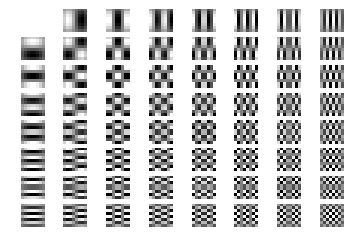

In [180]:
N = 8
fig = plot.figure()
for ind in range(1, N*N+N):
    img = np.real(basis_images('sin', N)[:,:,ind])
    fig.add_subplot(N, N, ind+1)
    if img.ndim == 2:
        plot.gray()
        plot.imshow(img)
        plot.axis('off')
    